Import libraries:

In [1]:
import seaborn as sns
import numpy as np
import pylab
import winsound
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
from mpl_toolkits import mplot3d
from tqdm import tqdm
import seaborn as sns

from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier
import matplotlib.animation as animation
import scipy.cluster.hierarchy as sch
from math import log, e
import shap
import re

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
from catboost import CatBoostClassifier

from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

from imblearn.under_sampling import RandomUnderSampler as UnderSampler
from imblearn.over_sampling import RandomOverSampler as OverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from IPython.display import Image
from celluloid import Camera
from matplotlib.animation import PillowWriter

from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

INFO:root:Using CPU


Parameters:

In [2]:
nan_threshold = 0.1
clusters_num = 10
corr_thres = 0.9

Classes:

In [3]:
class LoopingPillowWriter(PillowWriter):
    def finish(self):
        self._frames[0].save(self._outfile, save_all=True, append_images=self._frames[1:],
                             duration=int(1000/self.fps), loop=0)

CDFs: 

In [140]:
def ABS_SHAP(df_shap,df):
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index()

    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
        
    corr_df = pd.concat([pd.Series(feature_list), pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr'] > 0, 'red', 'blue')

    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df, left_on = 'Variable', right_on='Variable', how='inner')
    k2 = k2.sort_values(by='SHAP_abs', ascending = True)[:10]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable', y='SHAP_abs', color = colorlist, figsize=(5,16), legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
def get_percentage_missing(series):
    num = series.isnull().sum()
    den = len(series)
    return round(num/den, 2)

def pandas_entropy(column, base=None):
    vc = pd.Series(column).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

def drop_correlated(df, corr_threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    drop_list = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    return drop_list 

def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

Remove warnings:

In [5]:
import warnings
warnings.filterwarnings('ignore')

### NPS prediction

Spark request:

In [6]:
# Spark request
# train_test = spark.table('sptnps_dm.subs_nps_v9').drop('etl_run_id', 'processed_dttm')\
# .join(spark.table('sptnps_sb.subs_nps_rating'),['msisdn', 'business_dt'])
# df = train_test.toPandas()
# train_test.to_csv('data/critics_dash.csv', index=False)

Import data:

In [7]:
df_raw = pd.read_csv('data/critics_dash.csv')

del df_raw['min_traf_dttm']
del df_raw['is_nps_critic']

df_raw.set_index('msisdn', inplace=True)
winsound.Beep(440, 1000)

Fast A/B test:

In [8]:
df_clean = df_raw[['nps_rating', 'arpau_avg_hy1', 'active_days']].dropna()
df_clean.columns = ['nps_score', 'arpau, rub', 'lifetime, days']

min_len = int(min(len(df_clean[df_clean['nps_score'] <= 6]), len(df_clean[df_clean['nps_score'] >= 9])))

df_promos = df_clean[df_clean['nps_score'] >= 9].sample(n=min_len)
df_critics = df_clean[df_clean['nps_score'] <= 6].sample(n=min_len)

df_promos['LTV, rub']= df_promos['arpau, rub']*df_promos['lifetime, days']
df_critics['LTV, rub']= df_critics['arpau, rub']*df_critics['lifetime, days']

print('\nPromos MED(ARPAU):', int(np.median(df_promos['arpau, rub'])), 'rub')
print('Critics MED(ARPAU):', int(np.median(df_critics['arpau, rub'])), 'rub')

print('\nPromos MED(LT):', int(np.median(df_promos['lifetime, days'])), 'days')
print('Critics MED(LT):', int(np.median(df_critics['lifetime, days'])), 'days')


Promos MED(ARPAU): 503 rub
Critics MED(ARPAU): 510 rub

Promos MED(LT): 4137 days
Critics MED(LT): 4138 days


Plot arpau:

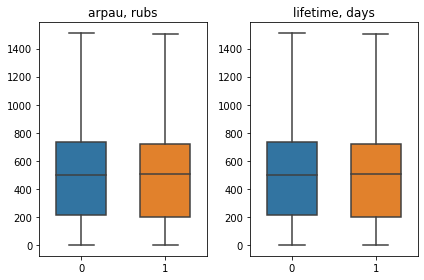

In [11]:
results_arpau, results_ltv = [], []

results_arpau.append(df_promos['arpau, rub'])
results_arpau.append(df_critics['arpau, rub'])
results_ltv.append(df_promos['lifetime, days'])
results_ltv.append(df_critics['lifetime, days'])

plt.subplot(1, 2, 1)
sns.boxplot(data=results_arpau, showfliers=False, width=0.6).set_title('arpau, rubs')

plt.subplot(1, 2, 2)
sns.boxplot(data=results_ltv, showfliers=False, width=0.6).set_title('lifetime, days')

plt.grid(False)
plt.tight_layout()
plt.show()

Make animation:

INFO:matplotlib.animation:Animation.save using <class '__main__.LoopingPillowWriter'>


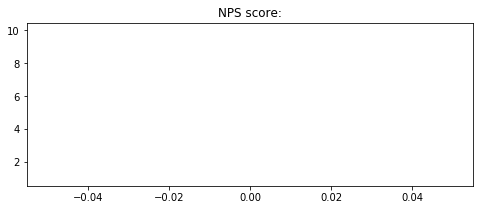

In [12]:
fig = plt.figure(figsize=(8,3))
plt.title('NPS score:')
camera = Camera(fig)

for i in range((len(df_raw)-10),len(df_raw)):
    plt.plot(df_raw['nps_rating'].values[i], 'oy', markersize=8)
    camera.snap()

animation = camera.animate()
animation.save('data/s.gif', writer = LoopingPillowWriter(fps=10))

Business dates:

Dates and feature numbers:

In [13]:
print('Business dates:', list(set(df_raw['business_dt'].values)))
del df_raw['business_dt']

Business dates: ['2019-12-31', '2019-05-31', '2019-11-30']


Number of features:

In [14]:
print('Initial number of features:', len(df_raw.columns))
df = df_raw.sample(frac=1)

Initial number of features: 3594


#### Preprocessing

Drop short-term features:

In [15]:
drop_list_regex = list(filter(re.compile(".*_m\d$").match, df.columns))
drop_list_regex.extend(list(filter(re.compile(".*_w\d$").match, df.columns)))
df.drop(drop_list_regex, axis=1, inplace=True)
winsound.Beep(440, 1000)

Remove highly correlated features, filter nans, process strings:

In [16]:
df = df.loc[:, df.isnull().mean() <= nan_threshold]
df.dropna(inplace=True)

drop_list = drop_correlated(df, corr_thres)
df.drop(drop_list, axis=1, inplace=True)
df[df.select_dtypes(['object']).columns] = df[df.select_dtypes(['object']).columns].applymap(lambda x: hash(x) % 100)
winsound.Beep(440, 1000)

Show shape and median score:

In [17]:
print('Dimensions:', df.shape)
print('Median score:', int(np.median(df['nps_rating'])))

Dimensions: (113734, 625)
Median score: 9


Prepare dataset:

In [104]:
df_test = df.sample(frac=0.1).copy()
df_test['score_bin'] = (df_test['nps_rating'] >= 9)
df_test = df_test.drop(['nps_rating'], axis = 1)

array = df_test.values
X = array[:,0:(len(df_test.columns)-1)]
Y = array[:,(len(df_test.columns)-1)].reshape(-1, 1).astype(int)
print('Resampled dataset shape: %s' % Counter(array[:,(len(df_test.columns)-1)]))

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median', verbose=1)
X = imputer.fit(X).transform(X)

ratio = round((len(Y)-np.count_nonzero(array[:,(len(df.columns)-1)]))/np.count_nonzero(array[:,(len(df.columns)-1)]),1)
print('Negative to positive ratio:', ratio)

Resampled dataset shape: Counter({True: 5741, False: 5632})
Negative to positive ratio: 1.0


Prepare train-test:

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)

#### Experiments

Train-test with XGBoost:

In [106]:
model = xgb.XGBClassifier(random_state=7, verbosity=1,  n_jobs=3)
model.fit(X_train, Y_train)
predicted = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

precision = float(precision_score(Y_test, predicted))
recall = float(recall_score(Y_test, predicted))
accuracy = float(accuracy_score(Y_test, predicted))
f1 = float(f1_score(Y_test, predicted))

print('\nHold-out precision:', round(precision*100), '%')
print('Hold-out recall:', round(recall*100), '%')
print('Hold-out F1:', round(f1*100), '%')
print('Hold-out accuracy:', round(accuracy*100), '%')

winsound.Beep(440, 1000)


Hold-out precision: 59 %
Hold-out recall: 64 %
Hold-out F1: 62 %
Hold-out accuracy: 60 %


Train-test with CatBoost:

In [107]:
model = CatBoostClassifier(random_state=7, learning_rate=0.01, thread_count=3)

model.fit(X_train, Y_train)
predicted = (model.predict_proba(X_test)[:,1] >= 0.5).astype(bool)

precision = float(precision_score(Y_test, predicted))
recall = float(recall_score(Y_test, predicted))
f1 = float(f1_score(Y_test, predicted))
accuracy = float(accuracy_score(Y_test, predicted))

print('\nHold-out precision:', round(precision*100), '%')
print('Hold-out recall:', round(recall*100), '%')
print('Hold-out F1:', round(f1*100), '%')
print('Hold-out accuracy:', round(accuracy*100), '%')

winsound.Beep(440, 1000)

0:	learn: 0.6929256	total: 41.9ms	remaining: 41.8s
1:	learn: 0.6926766	total: 76.1ms	remaining: 38s
2:	learn: 0.6925037	total: 108ms	remaining: 35.8s
3:	learn: 0.6922447	total: 140ms	remaining: 34.9s
4:	learn: 0.6920733	total: 172ms	remaining: 34.2s
5:	learn: 0.6918855	total: 202ms	remaining: 33.5s
6:	learn: 0.6916544	total: 233ms	remaining: 33.1s
7:	learn: 0.6914255	total: 269ms	remaining: 33.3s
8:	learn: 0.6912271	total: 302ms	remaining: 33.2s
9:	learn: 0.6909888	total: 333ms	remaining: 33s
10:	learn: 0.6907691	total: 364ms	remaining: 32.8s
11:	learn: 0.6906189	total: 399ms	remaining: 32.8s
12:	learn: 0.6904444	total: 434ms	remaining: 33s
13:	learn: 0.6902977	total: 469ms	remaining: 33s
14:	learn: 0.6900631	total: 504ms	remaining: 33.1s
15:	learn: 0.6898580	total: 537ms	remaining: 33s
16:	learn: 0.6896975	total: 568ms	remaining: 32.9s
17:	learn: 0.6894723	total: 603ms	remaining: 32.9s
18:	learn: 0.6892923	total: 635ms	remaining: 32.8s
19:	learn: 0.6891175	total: 674ms	remaining: 33s


164:	learn: 0.6691524	total: 5.38s	remaining: 27.2s
165:	learn: 0.6689993	total: 5.42s	remaining: 27.2s
166:	learn: 0.6689208	total: 5.45s	remaining: 27.2s
167:	learn: 0.6687872	total: 5.48s	remaining: 27.1s
168:	learn: 0.6686684	total: 5.51s	remaining: 27.1s
169:	learn: 0.6685294	total: 5.54s	remaining: 27.1s
170:	learn: 0.6684356	total: 5.58s	remaining: 27s
171:	learn: 0.6682904	total: 5.61s	remaining: 27s
172:	learn: 0.6681643	total: 5.64s	remaining: 27s
173:	learn: 0.6680805	total: 5.67s	remaining: 26.9s
174:	learn: 0.6680113	total: 5.71s	remaining: 26.9s
175:	learn: 0.6678930	total: 5.74s	remaining: 26.9s
176:	learn: 0.6678268	total: 5.77s	remaining: 26.8s
177:	learn: 0.6677523	total: 5.8s	remaining: 26.8s
178:	learn: 0.6676339	total: 5.84s	remaining: 26.8s
179:	learn: 0.6675344	total: 5.87s	remaining: 26.8s
180:	learn: 0.6674383	total: 5.91s	remaining: 26.8s
181:	learn: 0.6673654	total: 5.95s	remaining: 26.7s
182:	learn: 0.6672501	total: 5.98s	remaining: 26.7s
183:	learn: 0.66716

324:	learn: 0.6546628	total: 10.6s	remaining: 22s
325:	learn: 0.6545792	total: 10.6s	remaining: 22s
326:	learn: 0.6545047	total: 10.7s	remaining: 22s
327:	learn: 0.6544445	total: 10.7s	remaining: 21.9s
328:	learn: 0.6544119	total: 10.7s	remaining: 21.9s
329:	learn: 0.6543182	total: 10.8s	remaining: 21.9s
330:	learn: 0.6542433	total: 10.8s	remaining: 21.8s
331:	learn: 0.6541956	total: 10.8s	remaining: 21.8s
332:	learn: 0.6540873	total: 10.9s	remaining: 21.8s
333:	learn: 0.6540332	total: 10.9s	remaining: 21.7s
334:	learn: 0.6539299	total: 10.9s	remaining: 21.7s
335:	learn: 0.6538944	total: 11s	remaining: 21.7s
336:	learn: 0.6538046	total: 11s	remaining: 21.6s
337:	learn: 0.6537365	total: 11s	remaining: 21.6s
338:	learn: 0.6536355	total: 11.1s	remaining: 21.6s
339:	learn: 0.6535917	total: 11.1s	remaining: 21.5s
340:	learn: 0.6535220	total: 11.1s	remaining: 21.5s
341:	learn: 0.6534317	total: 11.2s	remaining: 21.5s
342:	learn: 0.6533529	total: 11.2s	remaining: 21.4s
343:	learn: 0.6532334	to

485:	learn: 0.6433854	total: 15.8s	remaining: 16.7s
486:	learn: 0.6433149	total: 15.9s	remaining: 16.7s
487:	learn: 0.6432314	total: 15.9s	remaining: 16.7s
488:	learn: 0.6431548	total: 15.9s	remaining: 16.6s
489:	learn: 0.6430704	total: 16s	remaining: 16.6s
490:	learn: 0.6430154	total: 16s	remaining: 16.6s
491:	learn: 0.6429524	total: 16s	remaining: 16.5s
492:	learn: 0.6428939	total: 16.1s	remaining: 16.5s
493:	learn: 0.6428273	total: 16.1s	remaining: 16.5s
494:	learn: 0.6427518	total: 16.1s	remaining: 16.5s
495:	learn: 0.6427236	total: 16.2s	remaining: 16.4s
496:	learn: 0.6426632	total: 16.2s	remaining: 16.4s
497:	learn: 0.6425745	total: 16.2s	remaining: 16.4s
498:	learn: 0.6425169	total: 16.3s	remaining: 16.3s
499:	learn: 0.6424456	total: 16.3s	remaining: 16.3s
500:	learn: 0.6424012	total: 16.3s	remaining: 16.3s
501:	learn: 0.6422909	total: 16.4s	remaining: 16.2s
502:	learn: 0.6422521	total: 16.4s	remaining: 16.2s
503:	learn: 0.6421873	total: 16.4s	remaining: 16.2s
504:	learn: 0.6421

647:	learn: 0.6333924	total: 21.1s	remaining: 11.5s
648:	learn: 0.6333161	total: 21.1s	remaining: 11.4s
649:	learn: 0.6332421	total: 21.1s	remaining: 11.4s
650:	learn: 0.6331789	total: 21.2s	remaining: 11.4s
651:	learn: 0.6331369	total: 21.2s	remaining: 11.3s
652:	learn: 0.6330774	total: 21.2s	remaining: 11.3s
653:	learn: 0.6330073	total: 21.3s	remaining: 11.3s
654:	learn: 0.6329460	total: 21.3s	remaining: 11.2s
655:	learn: 0.6328877	total: 21.3s	remaining: 11.2s
656:	learn: 0.6328171	total: 21.4s	remaining: 11.2s
657:	learn: 0.6327613	total: 21.4s	remaining: 11.1s
658:	learn: 0.6327084	total: 21.4s	remaining: 11.1s
659:	learn: 0.6326228	total: 21.5s	remaining: 11.1s
660:	learn: 0.6325539	total: 21.5s	remaining: 11s
661:	learn: 0.6325081	total: 21.5s	remaining: 11s
662:	learn: 0.6324333	total: 21.6s	remaining: 11s
663:	learn: 0.6324013	total: 21.6s	remaining: 10.9s
664:	learn: 0.6323456	total: 21.6s	remaining: 10.9s
665:	learn: 0.6322778	total: 21.7s	remaining: 10.9s
666:	learn: 0.6322

809:	learn: 0.6237409	total: 26.4s	remaining: 6.19s
810:	learn: 0.6237089	total: 26.4s	remaining: 6.16s
811:	learn: 0.6236678	total: 26.4s	remaining: 6.12s
812:	learn: 0.6236467	total: 26.5s	remaining: 6.09s
813:	learn: 0.6235720	total: 26.5s	remaining: 6.06s
814:	learn: 0.6234956	total: 26.5s	remaining: 6.03s
815:	learn: 0.6234533	total: 26.6s	remaining: 5.99s
816:	learn: 0.6233992	total: 26.6s	remaining: 5.96s
817:	learn: 0.6233416	total: 26.6s	remaining: 5.93s
818:	learn: 0.6232890	total: 26.7s	remaining: 5.89s
819:	learn: 0.6232142	total: 26.7s	remaining: 5.86s
820:	learn: 0.6231432	total: 26.7s	remaining: 5.83s
821:	learn: 0.6230652	total: 26.8s	remaining: 5.79s
822:	learn: 0.6229683	total: 26.8s	remaining: 5.76s
823:	learn: 0.6229077	total: 26.8s	remaining: 5.73s
824:	learn: 0.6228551	total: 26.9s	remaining: 5.7s
825:	learn: 0.6228014	total: 26.9s	remaining: 5.67s
826:	learn: 0.6226953	total: 26.9s	remaining: 5.63s
827:	learn: 0.6226332	total: 27s	remaining: 5.6s
828:	learn: 0.62

968:	learn: 0.6126073	total: 31.6s	remaining: 1.01s
969:	learn: 0.6124853	total: 31.7s	remaining: 980ms
970:	learn: 0.6124063	total: 31.7s	remaining: 947ms
971:	learn: 0.6123264	total: 31.7s	remaining: 914ms
972:	learn: 0.6122533	total: 31.8s	remaining: 882ms
973:	learn: 0.6121610	total: 31.8s	remaining: 849ms
974:	learn: 0.6120959	total: 31.8s	remaining: 816ms
975:	learn: 0.6120396	total: 31.9s	remaining: 784ms
976:	learn: 0.6119736	total: 31.9s	remaining: 751ms
977:	learn: 0.6118911	total: 31.9s	remaining: 718ms
978:	learn: 0.6118230	total: 32s	remaining: 686ms
979:	learn: 0.6117618	total: 32s	remaining: 653ms
980:	learn: 0.6116885	total: 32s	remaining: 620ms
981:	learn: 0.6116096	total: 32.1s	remaining: 588ms
982:	learn: 0.6115255	total: 32.1s	remaining: 555ms
983:	learn: 0.6114876	total: 32.1s	remaining: 522ms
984:	learn: 0.6113866	total: 32.2s	remaining: 490ms
985:	learn: 0.6113074	total: 32.2s	remaining: 457ms
986:	learn: 0.6112303	total: 32.2s	remaining: 424ms
987:	learn: 0.6111

Change threshold:

In [112]:
model = xgb.XGBClassifier(random_state=7, verbosity=1,  n_jobs=3)
model.fit(X_train, Y_train)
predicted = (model.predict_proba(X_test)[:,1] >= 0.66).astype(bool)

precision = float(precision_score(Y_test, predicted))
recall = float(recall_score(Y_test, predicted))
accuracy = float(accuracy_score(Y_test, predicted))
f1 = float(f1_score(Y_test, predicted))

print('\nHold-out precision:', round(precision*100), '%')
print('Hold-out recall:', round(recall*100), '%')
print('Hold-out F1:', round(f1*100), '%')
print('Hold-out accuracy:', round(accuracy*100), '%')

winsound.Beep(440, 1000)


Hold-out precision: 70 %
Hold-out recall: 6 %
Hold-out F1: 11 %
Hold-out accuracy: 52 %


K-Fold:

In [113]:
kfold = StratifiedKFold(n_splits=3, random_state=1)

Cross validation - precision:

In [114]:
cv_results_precision = cross_val_score(model, X, Y, cv=kfold, scoring='precision', verbose=1, n_jobs=3)
print('Precision: ', round(cv_results_precision.mean(),2), '/',round(cv_results_precision.std(), 2))
winsound.Beep(440, 1000)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.1s finished


Precision:  0.58 / 0.0


Cross validation - recall:

In [115]:
cv_results_recall = cross_val_score(model, X, Y, cv=kfold, scoring='recall', verbose=1, n_jobs=3)
print('Recall: ', round(cv_results_recall.mean(),2), '/',round(cv_results_recall.std(), 2))
winsound.Beep(440, 1000)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Recall:  0.62 / 0.0


Cross validation - roc_auc:

In [116]:
cv_results_roc = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc', verbose=1, n_jobs=3)
print('Recall: ', round(cv_results_roc.mean(),2), '/',round(cv_results_roc.std(), 2))
winsound.Beep(440, 1000)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


Recall:  0.61 / 0.01


Cross validation - F1:

In [119]:
cv_results_f1 = cross_val_score(model, X, Y, cv=kfold, scoring='f1', verbose=1, n_jobs=3)
print('F1: ', round(cv_results_f1.mean(),2), '/',round(cv_results_f1.std(), 2))
winsound.Beep(440, 1000)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.0s finished


F1:  0.6 / 0.0


Shap values - detailed:

In [120]:
model = CatBoostClassifier(random_state=7, learning_rate=0.01)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=7)
model.fit(X_train, Y_train)
winsound.Beep(440, 1000)

0:	learn: 0.6929256	total: 28.3ms	remaining: 28.3s
1:	learn: 0.6926766	total: 52.3ms	remaining: 26.1s
2:	learn: 0.6925037	total: 77.7ms	remaining: 25.8s
3:	learn: 0.6922447	total: 103ms	remaining: 25.6s
4:	learn: 0.6920733	total: 125ms	remaining: 24.9s
5:	learn: 0.6918855	total: 153ms	remaining: 25.4s
6:	learn: 0.6916544	total: 177ms	remaining: 25s
7:	learn: 0.6914255	total: 198ms	remaining: 24.6s
8:	learn: 0.6912271	total: 221ms	remaining: 24.4s
9:	learn: 0.6909888	total: 255ms	remaining: 25.2s
10:	learn: 0.6907691	total: 279ms	remaining: 25.1s
11:	learn: 0.6906189	total: 303ms	remaining: 25s
12:	learn: 0.6904444	total: 328ms	remaining: 24.9s
13:	learn: 0.6902977	total: 351ms	remaining: 24.8s
14:	learn: 0.6900631	total: 374ms	remaining: 24.5s
15:	learn: 0.6898580	total: 399ms	remaining: 24.5s
16:	learn: 0.6896975	total: 422ms	remaining: 24.4s
17:	learn: 0.6894722	total: 445ms	remaining: 24.3s
18:	learn: 0.6893425	total: 472ms	remaining: 24.4s
19:	learn: 0.6891560	total: 496ms	remainin

162:	learn: 0.6693599	total: 4.13s	remaining: 21.2s
163:	learn: 0.6692623	total: 4.16s	remaining: 21.2s
164:	learn: 0.6691523	total: 4.18s	remaining: 21.2s
165:	learn: 0.6690153	total: 4.21s	remaining: 21.1s
166:	learn: 0.6688804	total: 4.23s	remaining: 21.1s
167:	learn: 0.6687458	total: 4.26s	remaining: 21.1s
168:	learn: 0.6686276	total: 4.28s	remaining: 21.1s
169:	learn: 0.6684888	total: 4.31s	remaining: 21s
170:	learn: 0.6683758	total: 4.33s	remaining: 21s
171:	learn: 0.6682306	total: 4.36s	remaining: 21s
172:	learn: 0.6681646	total: 4.39s	remaining: 21s
173:	learn: 0.6680882	total: 4.41s	remaining: 20.9s
174:	learn: 0.6680151	total: 4.43s	remaining: 20.9s
175:	learn: 0.6678969	total: 4.46s	remaining: 20.9s
176:	learn: 0.6678308	total: 4.48s	remaining: 20.8s
177:	learn: 0.6677556	total: 4.5s	remaining: 20.8s
178:	learn: 0.6676379	total: 4.53s	remaining: 20.8s
179:	learn: 0.6675400	total: 4.55s	remaining: 20.7s
180:	learn: 0.6674243	total: 4.58s	remaining: 20.7s
181:	learn: 0.6673511

323:	learn: 0.6548159	total: 8.18s	remaining: 17.1s
324:	learn: 0.6547449	total: 8.2s	remaining: 17s
325:	learn: 0.6546616	total: 8.23s	remaining: 17s
326:	learn: 0.6545986	total: 8.25s	remaining: 17s
327:	learn: 0.6545383	total: 8.28s	remaining: 17s
328:	learn: 0.6545061	total: 8.31s	remaining: 16.9s
329:	learn: 0.6543943	total: 8.33s	remaining: 16.9s
330:	learn: 0.6543194	total: 8.36s	remaining: 16.9s
331:	learn: 0.6542699	total: 8.38s	remaining: 16.9s
332:	learn: 0.6541963	total: 8.41s	remaining: 16.8s
333:	learn: 0.6541416	total: 8.43s	remaining: 16.8s
334:	learn: 0.6540496	total: 8.46s	remaining: 16.8s
335:	learn: 0.6540133	total: 8.48s	remaining: 16.8s
336:	learn: 0.6539180	total: 8.5s	remaining: 16.7s
337:	learn: 0.6538494	total: 8.52s	remaining: 16.7s
338:	learn: 0.6538084	total: 8.55s	remaining: 16.7s
339:	learn: 0.6537634	total: 8.57s	remaining: 16.6s
340:	learn: 0.6536935	total: 8.59s	remaining: 16.6s
341:	learn: 0.6536032	total: 8.62s	remaining: 16.6s
342:	learn: 0.6535278	

484:	learn: 0.6436931	total: 12.1s	remaining: 12.9s
485:	learn: 0.6436436	total: 12.2s	remaining: 12.9s
486:	learn: 0.6435561	total: 12.2s	remaining: 12.8s
487:	learn: 0.6435148	total: 12.2s	remaining: 12.8s
488:	learn: 0.6434381	total: 12.2s	remaining: 12.8s
489:	learn: 0.6433564	total: 12.3s	remaining: 12.8s
490:	learn: 0.6433017	total: 12.3s	remaining: 12.7s
491:	learn: 0.6432553	total: 12.3s	remaining: 12.7s
492:	learn: 0.6431962	total: 12.3s	remaining: 12.7s
493:	learn: 0.6431234	total: 12.4s	remaining: 12.7s
494:	learn: 0.6430475	total: 12.4s	remaining: 12.6s
495:	learn: 0.6429924	total: 12.4s	remaining: 12.6s
496:	learn: 0.6429325	total: 12.4s	remaining: 12.6s
497:	learn: 0.6428710	total: 12.5s	remaining: 12.6s
498:	learn: 0.6428131	total: 12.5s	remaining: 12.5s
499:	learn: 0.6427572	total: 12.5s	remaining: 12.5s
500:	learn: 0.6427232	total: 12.5s	remaining: 12.5s
501:	learn: 0.6426119	total: 12.6s	remaining: 12.5s
502:	learn: 0.6425672	total: 12.6s	remaining: 12.4s
503:	learn: 

647:	learn: 0.6335871	total: 16.2s	remaining: 8.78s
648:	learn: 0.6335098	total: 16.2s	remaining: 8.75s
649:	learn: 0.6334602	total: 16.2s	remaining: 8.73s
650:	learn: 0.6334088	total: 16.2s	remaining: 8.7s
651:	learn: 0.6333667	total: 16.3s	remaining: 8.68s
652:	learn: 0.6333076	total: 16.3s	remaining: 8.65s
653:	learn: 0.6332419	total: 16.3s	remaining: 8.62s
654:	learn: 0.6331969	total: 16.3s	remaining: 8.6s
655:	learn: 0.6331385	total: 16.4s	remaining: 8.57s
656:	learn: 0.6330678	total: 16.4s	remaining: 8.55s
657:	learn: 0.6330125	total: 16.4s	remaining: 8.53s
658:	learn: 0.6329253	total: 16.4s	remaining: 8.51s
659:	learn: 0.6328390	total: 16.5s	remaining: 8.48s
660:	learn: 0.6328095	total: 16.5s	remaining: 8.45s
661:	learn: 0.6327574	total: 16.5s	remaining: 8.43s
662:	learn: 0.6326825	total: 16.5s	remaining: 8.4s
663:	learn: 0.6326216	total: 16.6s	remaining: 8.38s
664:	learn: 0.6325650	total: 16.6s	remaining: 8.35s
665:	learn: 0.6325070	total: 16.6s	remaining: 8.33s
666:	learn: 0.6

813:	learn: 0.6235779	total: 20.3s	remaining: 4.64s
814:	learn: 0.6235119	total: 20.3s	remaining: 4.62s
815:	learn: 0.6234365	total: 20.4s	remaining: 4.59s
816:	learn: 0.6233733	total: 20.4s	remaining: 4.57s
817:	learn: 0.6233119	total: 20.4s	remaining: 4.54s
818:	learn: 0.6232585	total: 20.4s	remaining: 4.52s
819:	learn: 0.6231664	total: 20.5s	remaining: 4.49s
820:	learn: 0.6230868	total: 20.5s	remaining: 4.47s
821:	learn: 0.6230044	total: 20.5s	remaining: 4.44s
822:	learn: 0.6229598	total: 20.6s	remaining: 4.42s
823:	learn: 0.6229232	total: 20.6s	remaining: 4.4s
824:	learn: 0.6228479	total: 20.6s	remaining: 4.37s
825:	learn: 0.6228064	total: 20.6s	remaining: 4.35s
826:	learn: 0.6227355	total: 20.7s	remaining: 4.32s
827:	learn: 0.6226732	total: 20.7s	remaining: 4.3s
828:	learn: 0.6226175	total: 20.7s	remaining: 4.27s
829:	learn: 0.6225513	total: 20.7s	remaining: 4.25s
830:	learn: 0.6224837	total: 20.8s	remaining: 4.22s
831:	learn: 0.6224300	total: 20.8s	remaining: 4.2s
832:	learn: 0.6

974:	learn: 0.6117973	total: 24.7s	remaining: 633ms
975:	learn: 0.6117445	total: 24.7s	remaining: 608ms
976:	learn: 0.6116521	total: 24.7s	remaining: 583ms
977:	learn: 0.6115691	total: 24.8s	remaining: 557ms
978:	learn: 0.6115015	total: 24.8s	remaining: 532ms
979:	learn: 0.6114108	total: 24.8s	remaining: 507ms
980:	learn: 0.6113456	total: 24.8s	remaining: 481ms
981:	learn: 0.6112338	total: 24.9s	remaining: 456ms
982:	learn: 0.6111543	total: 24.9s	remaining: 431ms
983:	learn: 0.6111110	total: 24.9s	remaining: 405ms
984:	learn: 0.6110174	total: 24.9s	remaining: 380ms
985:	learn: 0.6109305	total: 25s	remaining: 355ms
986:	learn: 0.6108481	total: 25s	remaining: 329ms
987:	learn: 0.6107699	total: 25s	remaining: 304ms
988:	learn: 0.6107185	total: 25s	remaining: 279ms
989:	learn: 0.6106008	total: 25.1s	remaining: 253ms
990:	learn: 0.6105395	total: 25.1s	remaining: 228ms
991:	learn: 0.6104907	total: 25.1s	remaining: 203ms
992:	learn: 0.6103842	total: 25.1s	remaining: 177ms
993:	learn: 0.610307

Shap values:

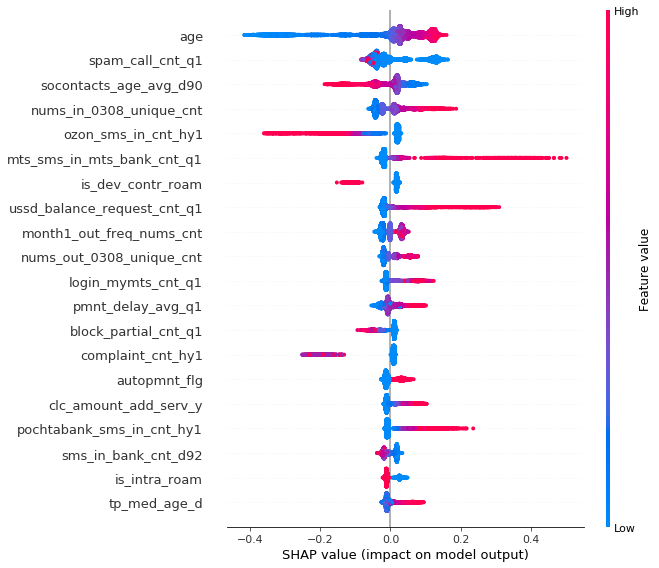

In [122]:
Y = df_test['score_bin']
X = df_test.loc[:, df_test.columns != 'score_bin']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=df.loc[:, df.columns != 'score_bin'].columns)

Shap values - integrated:

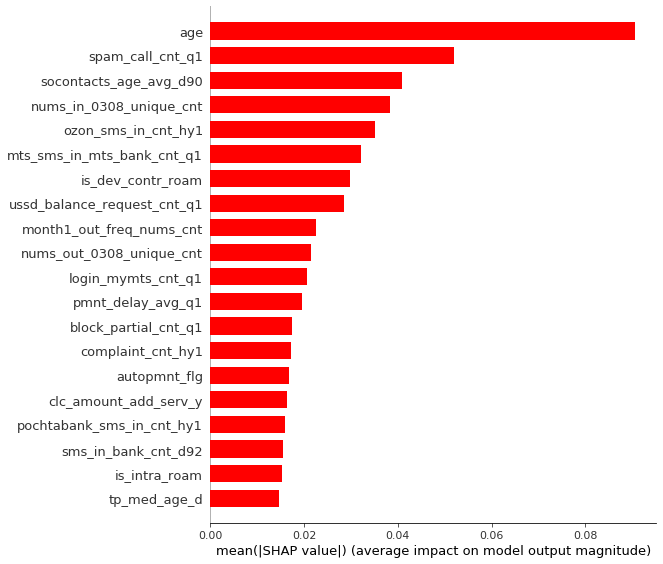

In [144]:
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=X_train.columns, color='r', auto_size_plot=True)

Partial dependencies for age:

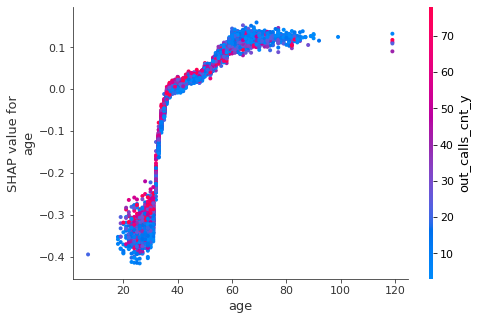

In [146]:
shap.dependence_plot('age', shap_values, X_train)

TOP list of features:

In [127]:
vals= np.abs(shap_values).mean(0)
fi = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['feature','feature_importance_vals'])
fi.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
fl = list(fi['feature'])
fi.reset_index(drop=True, inplace=True)
fi.set_index('feature', inplace=True)
fi.head(5)

,feature_importance_vals
feature,
age,0.090598
spam_call_cnt_q1,0.051970
socontacts_age_avg_d90,0.040955
nums_in_0308_unique_cnt,0.038395
ozon_sms_in_cnt_hy1,0.035210


Write feature list to file:

In [93]:
with open('data/features.txt','w') as f:
    f.write('\n'.join(fl))